# Chargement des données

In [1]:
import pandas as pd
import numpy as np
import re

DF_ideal_only = pd.read_csv("clean_data\idealwine_2020-11-21.csv")   # Données Idealwine sans jointure avec données RVF
DF_ideal_rvf0 = pd.read_csv("clean_data\idealwine_larvf_2020-11-26.csv")   # Données Idealwine jointes lorsque possible à celles de la RVF

# Suppression des "vieux" vins, trop rares pour faire l'objet d'une cote fiable :
DF_ideal_only = DF_ideal_only[DF_ideal_only.millesime>=1996]
DF_ideal_rvf0 = DF_ideal_rvf0[DF_ideal_rvf0.millesime>=1996]

DF_ideal_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38499 entries, 0 to 62040
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nom_du_vin      38499 non-null  object 
 1   millesime       38499 non-null  int64  
 2   pays_region     38499 non-null  object 
 3   domaine         38499 non-null  object 
 4   appellation     38499 non-null  object 
 5   couleur         38499 non-null  object 
 6   cote_1992       0 non-null      float64
 7   cote_1993       0 non-null      float64
 8   cote_1994       0 non-null      float64
 9   cote_1995       0 non-null      float64
 10  cote_1996       0 non-null      float64
 11  cote_1997       1 non-null      float64
 12  cote_1998       40 non-null     float64
 13  cote_1999       611 non-null    float64
 14  cote_2000       1158 non-null   float64
 15  cote_2001       1300 non-null   float64
 16  cote_2002       1493 non-null   float64
 17  cote_2003       2079 non-null  

In [16]:
# Suppression des doublons dans la table jointe (lorsqu'un même vin a plusieurs notes RVF) :

L_col_ideal = ['nom_du_vin', 'millesime', 'pays_region', 'domaine', 'appellation', 'couleur', 'cote_1992', 'cote_1993', 'cote_1994', 'cote_1995', 'cote_1996', 'cote_1997', 'cote_1998', 'cote_1999', 'cote_2000', 'cote_2001', 'cote_2002', 'cote_2003', 'cote_2004', 'cote_2005', 'cote_2006', 'cote_2007', 'cote_2008', 'cote_2009', 'cote_2010', 'cote_2011', 'cote_2012', 'cote_2013', 'cote_2014', 'cote_2015', 'cote_2016', 'cote_2017', 'cote_2018', 'cote_2019', 'cote_2020', 'note_Burghound', 'note_JMQ', 'note_JR', 'note_VinousA', 'note_WA', 'note_WS']
L_col_rvf = ['rvf_domain_stars', 'rvf_review_score_float']
DF_ideal_rvf = DF_ideal_rvf0.groupby(L_col_ideal, dropna=False, as_index=False)[L_col_rvf].median()
DF_ideal_rvf.info()
# Même nombre de lignes que dans DF_ideal : 38499


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38499 entries, 0 to 38498
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nom_du_vin              38499 non-null  object 
 1   millesime               38499 non-null  int64  
 2   pays_region             38499 non-null  object 
 3   domaine                 38499 non-null  object 
 4   appellation             38499 non-null  object 
 5   couleur                 38499 non-null  object 
 6   cote_1992               0 non-null      float64
 7   cote_1993               0 non-null      float64
 8   cote_1994               0 non-null      float64
 9   cote_1995               0 non-null      float64
 10  cote_1996               0 non-null      float64
 11  cote_1997               1 non-null      float64
 12  cote_1998               40 non-null     float64
 13  cote_1999               611 non-null    float64
 14  cote_2000               1158 non-null 

In [3]:
# Choix de la base de données à utiliser dans la suite :
with_rvf = False
if with_rvf:
    DF_ideal = DF_ideal_rvf
else:
    DF_ideal = DF_ideal_only

# Préparation des données pour les modèles de "test" : entraînement avec des variables explicatives de 2010 et une cible 2015, test avec des variables explicatives 2015 et une cible 2020

In [18]:
MIN_YEAR = 1992
MAX_YEAR = 2020

# FONCTION D'ENRICHISSEMENT DES DONNEES (Constitution des variables explicatives) :
def get_year_data(DF_all, year=2010, delta=5, with_target=True, verbose=True):
    present = str(year)
    future = str(year + delta)

    # Une observation de la base d'apprentissage doit forcément avoir une cote sur l'année year 
    # et une cote sur l'année (year + delta).
    if with_target:
        DF_selected = DF_all[(~DF_all['cote_'+present].isna()) & (~DF_all['cote_'+future].isna())].copy()
    else:  # Pour la base de test 2020, pas de cible connue !
        DF_selected = DF_all[(~DF_all['cote_'+present].isna())].copy()
    if verbose: 
        print("    Observations filtrées en fonction de la présence des cotes des années n (et n+5 si opportun).")

    # Comme variables explicatives relatives à la valeur du vin, je choisis les inflations annuelles relatives
    # plutôt que les valeurs absolues, et je garde la dernière cote connue, qui donne une indication
    # de la catégorie du vin (cher, moins cher...) :
    DF_selected['cote'] = DF_selected['cote_'+present]
    for y in range(MIN_YEAR+1, year+1):
        DF_selected['infl_' + str(year-y)] = DF_selected.apply(
            lambda S : ((S['cote_'+str(y)] - S['cote_'+str(y-1)]) / S['cote_'+str(y-1)]) \
                       if (S['cote_'+str(y)]!=np.nan and S['cote_'+str(y-1)]!=np.nan and S['cote_'+str(y-1)]!=0) \
                       else np.nan,
            axis=1
        )
    if verbose: 
        print("    Variables d'inflation générées.")

    # Suppression des vins à moins de 20 euros la bouteille, qui ont a priori peu de potentiel :
    DF_selected = DF_selected[DF_selected['cote']>=20]

    # Définition des colonnes RVF à prendre en compte :
    L_col_rvf_score = [c] if (c := 'rvf_review_score_float') in DF_selected.columns.tolist() else []
    L_col_rvf_stars = [c] if (c := 'rvf_domain_stars') in DF_selected.columns.tolist() else []
    
    # Ajout de variables de moyennes relatives au vin (i.e. à l'ensemble des millésimes connus du même vin) :
    L_groupby = ['nom_du_vin', 'pays_region', 'domaine', 'appellation', 'couleur']
    L_to_aggregate = ['cote'] + [c for c in DF_selected.columns if c[:5]=='infl_'] + L_col_rvf_score
    D_new_names = {c: 'vin_moy_'+c for c in L_to_aggregate}
    DF_wine_avg = DF_selected[L_groupby + L_to_aggregate].groupby(L_groupby, as_index=False).mean().rename(D_new_names, axis=1)
    DF_selected = DF_selected.merge(DF_wine_avg, on=L_groupby)

    # Ajout de variables de maximum relatives au vin (i.e. à l'ensemble des millésimes connus du même vin) :
    L_to_aggregate = ['cote'] + L_col_rvf_score
    D_new_names = {c: 'vin_max_'+c for c in L_to_aggregate}
    DF_wine_max = DF_selected[L_groupby + L_to_aggregate].groupby(L_groupby, as_index=False).max().rename(D_new_names, axis=1)
    DF_selected = DF_selected.merge(DF_wine_max, on=L_groupby)
    if verbose: 
        print("    Variables associées au vin ajoutées.")

    # Ajout de variables de moyennes relatives au domaine (i.e. à l'ensemble des vins connus du même domaine) :
    L_groupby = ['pays_region', 'domaine']
    L_to_aggregate = [c for c in DF_selected.columns if c[:5]=='infl_'] + L_col_rvf_score
    D_new_names = {c: 'dom_moy_'+c for c in L_to_aggregate}
    DF_dom_avg = DF_selected[L_groupby + L_to_aggregate].groupby(L_groupby, as_index=False).mean().rename(D_new_names, axis=1)
    DF_selected = DF_selected.merge(DF_dom_avg, on=L_groupby)

    # Ajout de variables de maximum relatives au domaine :
    L_to_aggregate = ['cote'] + L_col_rvf_score + L_col_rvf_stars
    D_new_names = {c: 'dom_max_'+c for c in L_to_aggregate}
    DF_dom_max = DF_selected[L_groupby + L_to_aggregate].groupby(L_groupby, as_index=False).max().rename(D_new_names, axis=1)
    DF_selected = DF_selected.merge(DF_dom_max, on=L_groupby)
    if verbose: 
        print("    Variables associées au domaine ajoutées.")

    # Ajout de variables de moyennes relatives à l'appellation (i.e. à l'ensemble des vins connus sur cette appellation) :
    L_groupby = ['pays_region', 'appellation']
    L_to_aggregate = ['cote'] + [c for c in DF_selected.columns if c[:5]=='infl_']
    D_new_names = {c: 'app_moy_'+c for c in L_to_aggregate}
    DF_app_avg = DF_selected[L_groupby + L_to_aggregate].groupby(L_groupby, as_index=False).mean().rename(D_new_names, axis=1)
    DF_selected = DF_selected.merge(DF_app_avg, on=L_groupby)

    # Ajout de variables de maximum relatives à l'appellation :
    L_to_aggregate = ['cote']
    D_new_names = {c: 'app_max_'+c for c in L_to_aggregate}
    DF_app_max = DF_selected[L_groupby + L_to_aggregate].groupby(L_groupby, as_index=False).max().rename(D_new_names, axis=1)
    DF_selected = DF_selected.merge(DF_app_max, on=L_groupby)
    if verbose: 
        print("    Variables associées à l'appellation ajoutées.")

    # Mise en évidence de la variable cible à prédire, en dernière colonne.
    # Le choix fait ici est de prendre l'inflation relative sur (delta) années :
    if with_target:
        DF_selected['cible'] = (DF_selected['cote_'+future] - DF_selected['cote_'+present]) / DF_selected['cote_'+present]

    # Suppression des colonnes non retenues :
    L_col_to_drop = [('cote_'+str(y)) for y in range(MIN_YEAR, MAX_YEAR+1)]
    DF_selected = DF_selected.drop(columns=L_col_to_drop)
    if verbose: 
        print("    Colonnes inutiles supprimées.")
        """ print("    Colonnes restantes :", DF_selected.columns.tolist()) """
    
    return DF_selected     

In [19]:
# FONCTION DE PREPARATION DES DONNEES (sélection des variables explicatives) :
def get_ready_data(DF_ideal, year_train=2010, delta=5, with_test_target=True):
    year_test = year_train + delta 

    # Récupérer les données 'enrichies' par la fonction get_year_data() :
    print("Enrichissement du jeu d'entraînement...")
    L_DF_train0 = list()
    nb_years_train = 1  # doit être >= 1. En pratique, pas de gain constaté au-delà de 1 sur le cas d'usage investissement
    for year_data in range(max(2005, year_train - nb_years_train + 1), year_train + 1):
        print("  Année :", year_data)
        L_DF_train0.append(get_year_data(DF_ideal, year_data, delta))
    DF_train0 = pd.concat(L_DF_train0, axis=0)
    
    print("Enrichissement du jeu de test...")
    DF_test0 = get_year_data(DF_ideal, year_test, delta, with_target=with_test_target)

    # Traitement des valeurs manquantes :
    # La solution "rapide" retenue ici est de ne garder que les variables renseignées sur une forte
    # proportion d'enregistrements de la base d'entraînement, puis de supprimer les observations
    # présentant des valeurs manquantes :
    RANDOM_STATE = 4307
    ratio_max_null = 0.10  # 0.10
    S_nbnull = DF_train0.isna().sum()
    L_col_to_keep = DF_train0.columns[S_nbnull <= ratio_max_null*len(DF_train0)].tolist()     
    DF_train = DF_train0[L_col_to_keep].dropna().sample(frac=1, random_state=RANDOM_STATE) 
    if (not with_test_target):
        L_col_to_keep.remove('cible')
    DF_test = DF_test0[L_col_to_keep].dropna().sample(frac=1, random_state=RANDOM_STATE)
    print("Taille de la base d'entraînement avant gestion des valeurs manquantes :", len(DF_train0)) 
    print("Taille de la base d'entraînement après gestion des valeurs manquantes :", len(DF_train)) 
    print("Nombre de valeurs nulles dans les champs issus de la RVF :", S_nbnull[[c for c in DF_train0.columns if c.find('rvf_')>-1]])

    """ Vérification temporaire :
    DF_train0[DF_train0.vin_moy_rvf_review_score_float.isna()].to_csv('test.csv', index=False) """

    # IMPORTANT (CHOIX NON TRIVIAL) : l'appellation et le domaine sont peut-être des variables
    # explicatives trop "faciles" qui risquent de produire un modèle qui ne supportera pas le glissement
    # dans le temps (ex: valable en 2010 pour prédire 2015 mais de faible performance en 2015 pour 
    # prédire 2020).
    L_to_drop = ['nom_du_vin', 'millesime', 'appellation']  # Meilleur choix empirique si XGBoost et réseau de neurones
    """ L_to_drop = ['nom_du_vin', 'appellation', 'domaine', 'millesime']  # Meilleur choix empirique si random forest """
    """ L_to_drop = ['nom_du_vin', 'millesime']  # autre possibilité """
    """ L_to_drop = ['nom_du_vin']  # autre possibilité maximaliste """

    # Séparation entre variables explicatives et variable cible :
    DF_X_train0 = DF_train.drop(columns=L_to_drop).iloc[:,:-1]
    DF_y_train0 = DF_train[['cible']]
    DF_X_test0 = DF_test.drop(columns=L_to_drop)
    if with_test_target:
        DF_X_test0 = DF_X_test0.iloc[:,:-1]
        DF_y_test0 = DF_test[['cible']]
    print("Dimension du jeu d'entraînement :", DF_X_train0.values.shape)
    print("Dimension du jeu de test :", DF_X_test0.values.shape)
    print("Colonnes retenues :", DF_X_train0.columns.tolist())

    # Passage en variables numériques ('dummies') des variables catégorielles, en l'occurrence
    # les trois premières colonnes (millésime, pays_region, couleur)
    # + normalisation des autres variables :
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    nb_cat_columns = 6 - len(L_to_drop)
    L_last_col = DF_X_train0.columns.tolist()[nb_cat_columns:]

    Encoder = OneHotEncoder(handle_unknown='ignore')
    Scaler = StandardScaler()
    X_train = np.concatenate(
        [Encoder.fit_transform(DF_X_train0.values[:,:nb_cat_columns]).toarray(),
        Scaler.fit_transform(DF_X_train0.values[:,nb_cat_columns:])],
        axis=1)
    X_test = np.concatenate(
        [Encoder.transform(DF_X_test0.values[:,:nb_cat_columns]).toarray(), 
         Scaler.fit_transform(DF_X_test0.values[:,nb_cat_columns:])], 
        axis=1)               

    # Affichage du nombre de variables :
    print("Nombre de variables explicatives après transformation :", X_train.shape[1])

    y_train = DF_y_train0.values.squeeze()
    y_test = None
    if with_test_target:
        y_test = DF_y_test0.values.squeeze()

    return X_train, X_test, y_train, y_test, DF_test, L_last_col

In [6]:
# PREPARATION EFFECTIVE DES DONNEES POUR LE MODELE DE "TEST" :

current_year = 2020
delta = 5
year_train = current_year - 2*delta
year_test = year_train + delta 

X_train, X_test, y_train, y_test, DF_test, L_last_col = get_ready_data(DF_ideal, year_train, delta, with_test_target=True)

# En l'absence de jointure avec RVF, 21 colonnes attendues avant application du OneHotEncoder : 
# ['pays_region', 'domaine', 'couleur', 'cote', 'vin_moy_cote', 'vin_moy_infl_1', 'vin_moy_infl_0', 'vin_max_cote', 'dom_moy_infl_3', 'dom_moy_infl_2', 'dom_moy_infl_1', 'dom_moy_infl_0', 'dom_max_cote', 'app_moy_cote', 'app_moy_infl_5', 'app_moy_infl_4', 'app_moy_infl_3', 'app_moy_infl_2', 'app_moy_infl_1', 'app_moy_infl_0', 'app_max_cote']

Enrichissement du jeu d'entraînement...
  Année : 2010
    Observations filtrées en fonction de la présence des cotes des années n (et n+5 si opportun).
    Variables d'inflation générées.
    Variables associées au vin ajoutées.
    Variables associées au domaine ajoutées.
    Variables associées à l'appellation ajoutées.
    Colonnes inutiles supprimées.
Enrichissement du jeu de test...
    Observations filtrées en fonction de la présence des cotes des années n (et n+5 si opportun).
    Variables d'inflation générées.
    Variables associées au vin ajoutées.
    Variables associées au domaine ajoutées.
    Variables associées à l'appellation ajoutées.
    Colonnes inutiles supprimées.
Taille de la base d'entraînement avant gestion des valeurs manquantes : 5621
Taille de la base d'entraînement après gestion des valeurs manquantes : 4714
Nombre de valeurs nulles dans les champs issus de la RVF : Series([], dtype: int64)
Dimension du jeu d'entraînement : (4714, 21)
Dimension du jeu de t

# Modèle de machine learning de 'test' : entraînement avec des variables explicatives de 2010 et une cible 2015, test avec des variables explicatives 2015 et une cible 2020

In [26]:
# FONCTION D'ENTRAINEMENT DU MODELE :
# Améliorations envisageables :
# - reprendre les essais en Lasso (linéaire) avec ajout de variables par PolynomialFeatures ou par un autre moyen ?

from xgboost import XGBRFRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

def train(X_train, y_train, y_test, L_max_depth=[16], with_test_target=True, alpha=0.6):
    # Etablissement de poids, visant à favoriser une meilleure prédiction pour les vins de 
    # plus forte inflation, qui sont ceux sur lesquels l'erreur peut avoir le plus de coût
    # dans un cas d'usage d'investissement.
    # A ETUDIER : optimisation de ces poids
    from scipy.special import expit as sigmoid
    train_weights = sigmoid(alpha * (y_train - np.mean(y_train)) / np.std(y_train))

    print("Min et max des poids d'entraînement :", np.min(train_weights), np.max(train_weights))
    if with_test_target:
        test_weights = sigmoid(alpha * (y_test - np.mean(y_test)) / np.std(y_test))
        print("Ecart-type, min et max des poids de test :", np.std(test_weights), np.min(test_weights), np.max(test_weights))
    else:
        test_weights = None

    # Entraînement d'un modèle :
    choice = 'xgboost'
    if choice=='lasso':
        model0 = Lasso()
        params = {
            'alpha': [0.001, 0.01, 0.1]
        }
    elif choice=='svm':
        model0 = SVR(kernel='rbf')
        params = {
            'C': [30, 100, 300, 1000],
            'gamma': [0.01, 0.03, 0.1, 0.3]
        }
    elif choice=='forest': 
        model0 = RandomForestRegressor()
        params = {
            'max_depth': L_max_depth, # En base complète, meilleurs résultats autour de 100
            'min_samples_leaf': [3],  # En base complète, meilleurs résultats à 2; à 3 en base légère
            'min_samples_split': [4],
            'n_estimators': [70, 80, 90]  # En base complète, meilleurs résultats autour de 80
        }
    else:  # XGboost de forêts aléatoires : les meilleurs résultats à ce stade, donc choix par défaut
        model0 = XGBRFRegressor()
        params = {
            'max_depth': L_max_depth,  # Optimums constatés entre 12 et 16
            'n_estimators': [400]  # Pas de progrès constaté au-delà de 400
        }

    grid = GridSearchCV(model0, param_grid=params, cv=5, verbose=11, return_train_score=True, n_jobs=-1)
    grid.fit(X_train, y_train, sample_weight=train_weights)

    return grid, train_weights, test_weights


In [27]:
# ENTRAINEMENT DU MODELE DE "TEST", PUIS AFFICHAGE DES SCORES :
grid, train_weights, test_weights = train(X_train, y_train, y_test, L_max_depth=[16])

print("Meilleurs paramètres trouvés :", grid.best_params_)
best_model = grid.best_estimator_  # instance de la classe concernée avec les bons param.
print("Score d'entraînement :", best_model.score(X_train, y_train, sample_weight=train_weights))
print("Score moyen de cross-validation :", grid.cv_results_['mean_test_score'][0])
print("Score de test :", best_model.score(X_test, y_test, sample_weight=test_weights))


Min et max des poids d'entraînement : 0.16110147730223867 0.9995048793343717
Ecart-type, min et max des poids de test : 0.11703823607456978 0.1666119110628884 0.9998273829799944
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.3min remaining:   53.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
Meilleurs paramètres trouvés : {'max_depth': 16, 'n_estimators': 400}
Score d'entraînement : 0.7859389024966162
Score moyen de cross-validation : 0.40778911826986997
Score de test : 0.22242078708992696


In [28]:
# Simulation de scénario d'investissement et évaluation :
DF_invest = DF_test.copy()
DF_invest['prediction'] = best_model.predict(X_test)

infl_moy = DF_invest.cible.mean()
print("Moyenne de l'inflation des vins entre ", year_test, "et", year_test+delta, ":", infl_moy)

nb_domaines = 20
DF_invest = DF_invest.sort_values(by=['prediction'], ascending=False)

DF_invest = DF_invest.reset_index().groupby(['pays_region', 'domaine']).first().reset_index().set_index('index')
DF_invest = DF_invest.sort_values(by=['prediction'], ascending=False).head(nb_domaines)
DF_invest = DF_invest.sort_values(by=['pays_region', 'domaine'])
invest_moy = DF_invest.cible.mean()
print("Moyenne de l'inflation des vins proposés à l'investissement entre ", year_test, "et", year_test+delta, ":", invest_moy)
print("Voici les vins proposés :")
display(DF_invest)

Moyenne de l'inflation des vins entre  2015 et 2020 : 0.309242232482932
Moyenne de l'inflation des vins proposés à l'investissement entre  2015 et 2020 : 1.2766323177703236
Voici les vins proposés :


,pays_region,domaine,nom_du_vin,millesime,appellation,couleur,cote,vin_moy_cote,vin_moy_infl_1,vin_moy_infl_0,...,app_moy_cote,app_moy_infl_5,app_moy_infl_4,app_moy_infl_3,app_moy_infl_2,app_moy_infl_1,app_moy_infl_0,app_max_cote,cible,prediction
index,,,,,,,,,,,,,,,,,,,,,
2633,Bourgogne,Armand Rousseau,Chambertin Clos de Bèze Grand Cru Armand Rousseau,1997,Chambertin Clos de Bèze,Rouge,288.10,664.757647,0.127088,0.178693,...,238.451897,0.019204,0.092890,0.168489,0.060954,0.098882,0.117971,1170.00,0.465463,2.054810
4358,Bourgogne,Arnoux-Lachaux,Romanée-Saint-Vivant Grand Cru Arnoux-Lachaux,2001,Romanée-Saint-Vivant,Rouge,110.62,277.376667,0.103446,0.154105,...,610.513210,0.016553,0.109571,0.199905,0.027114,0.104156,0.156273,1726.29,0.498825,1.211217
14885,Bourgogne,Comte Liger-Belair,La Romanée Grand Cru Comte Liger-Belair,2000,La Romanée,Rouge,464.43,857.361818,0.085281,0.110412,...,857.361818,0.040408,0.138348,0.187743,0.151438,0.085281,0.110412,1817.59,1.294146,1.171915
3852,Bourgogne,Denis Mortet,Gevrey-Chambertin 1er Cru Les Champeaux Denis ...,2011,Gevrey-Chambertin,Rouge,72.00,116.878000,0.085080,0.272642,...,91.033446,0.011413,0.087298,0.112664,0.024374,0.080261,0.125287,284.00,0.293333,1.354474
771,Bourgogne,Domaine d'Eugénie (René Engel),Vosne-Romanée 1er Cru Les Brûlées Domaine René...,2003,Vosne-Romanée,Rouge,70.37,148.123333,0.099622,0.454594,...,157.696060,0.022975,0.096666,0.122132,0.049681,0.085926,0.127143,1560.00,0.396618,1.355050
1476,Bourgogne,Dominique Laurent,Mazis-Chambertin Grand Cru Dominique Laurent,1996,Mazis-Chambertin,Rouge,72.14,99.153636,0.080912,0.136063,...,269.096102,-0.060377,0.038312,0.086303,0.015624,0.032381,0.111064,1080.00,0.974633,1.251357
10167,Bourgogne,Dujac,Morey Saint-Denis Dujac,2008,Morey Saint-Denis,Rouge,37.92,61.857143,0.106319,0.108745,...,77.377627,0.014889,0.096240,0.139281,0.052969,0.088512,0.110514,150.88,0.673259,1.308038
3170,Bourgogne,Faiveley,Musigny Grand Cru Faiveley,1998,Musigny,Rouge,485.21,997.536667,0.091116,0.179369,...,850.704141,0.029041,0.097163,0.202824,0.128585,0.112992,0.136748,3838.58,0.586365,1.186938
13765,Bourgogne,François Lamarche,La Grande Rue Grand Cru François Lamarche,2004,La Grande Rue,Rouge,96.01,181.478571,0.083408,0.339988,...,181.478571,0.010467,0.070090,0.117654,0.062204,0.083408,0.339988,264.00,1.835225,1.172030


In [20]:
# FONCTION DE SAUVEGARDE (EXPORT) DES DONNEES intégrant la prédiction établie :
import time

def save_pred(DF_ideal, year_test, delta, DF_test, X_test, best_model, with_target=True, uncrush=None):
    DF_test_pred = DF_test.copy()
    DF_test_pred['pred_infl'] = best_model.predict(X_test)
    if uncrush!=None:
        DF_test_pred['pred_infl'] = uncrush(DF_test_pred['pred_infl'].values)

    L_to_keep = ['pays_region', 'appellation', 'domaine', 'nom_du_vin', 'couleur', 'millesime', 'pred_infl']
    if with_target:
        L_to_keep = L_to_keep + ['cible']
    DF_test_pred = DF_test_pred[L_to_keep]
    DF_ideal_pred = DF_ideal.merge(DF_test_pred)
    DF_ideal_pred['pred_cote'] = DF_ideal_pred.apply(lambda S: (1 + S['pred_infl'])*S['cote_'+str(year_test)], axis=1)

    filename = 'predicted_data/idealwine_pred_'+str(year_test)+'_'+str(year_test+delta)+'_'+str(int(time.time()))+'.csv'
    DF_ideal_pred.to_csv(filename)


In [13]:
# SAUVEGARDE EFFECTIVE intégrant la prédiction établie en 2015 :

save_pred(DF_ideal, year_test, delta, DF_test, X_test, best_model, with_target=True)

# Réseau de neurones de 'test' : machine learning pour 2015 (à partir de données 2010) puis sauvegarde des prédictions pour 2020

In [22]:
# CLASSES ET FONCTIONS UTILES POUR LA DEFINITION DU MODELE ET LA PREPARATION DES CIBLES :

import tensorflow as tf

class IdealwineModel(tf.keras.Model):
    def __init__(self, nbvar, L_last_col_names):
        super().__init__(name="idealwine")
        self.nbvar = nbvar
        self.L_last_col_names = L_last_col_names

        all_false = np.full((nbvar-len(L_last_col_names),), False, dtype=np.bool)
        self.mask_vin = np.append(all_false, [c.startswith('vin_moy_infl_') for c in L_last_col_names])
        self.mask_app = np.append(all_false, [c.startswith('app_moy_infl_') for c in L_last_col_names])
        self.mask_dom = np.append(all_false, [c.startswith('dom_moy_infl_') for c in L_last_col_names])
        self.mask_else = np.logical_not(np.logical_or(self.mask_vin, np.logical_or(self.mask_app, self.mask_dom)))
        self.nb_else = np.sum(self.mask_else.astype(np.int))

        self.dense_else_dim = 16    # 16
        self.lstm_dim = 8   # 8
        self.dropout_strength = 0.35    # 0.35
        self.lstm_vin = tf.keras.layers.LSTM(self.lstm_dim, return_sequences=False, name='lstm_vin')
        self.lstm_app = tf.keras.layers.LSTM(self.lstm_dim, return_sequences=False, name='lstm_app')
        self.lstm_dom = tf.keras.layers.LSTM(self.lstm_dim, return_sequences=False, name='lstm_dom')
        self.dense_else = tf.keras.layers.Dense(
            units=self.dense_else_dim,
            input_shape=[self.nb_else],
            name='dense_else'
        )
        self.L_layers = [
            tf.keras.layers.Dropout(self.dropout_strength, name='dropout0'),
            tf.keras.layers.Dense(units=(self.dense_else_dim//2 + self.lstm_dim), name='dense0'),
            tf.keras.layers.LeakyReLU(name='leaky0'),
            tf.keras.layers.Dense(units=min(16, self.dense_else_dim//4 + self.lstm_dim//2), name='dense1'),
            tf.keras.layers.LeakyReLU(name='leaky1'),
            tf.keras.layers.Dropout(self.dropout_strength, name='dropout1'),
            tf.keras.layers.Dense(units=16, name='dense2'),
            tf.keras.layers.LeakyReLU(name='leaky2'),
            tf.keras.layers.Dense(units=8, name='dense3'),
            tf.keras.layers.LeakyReLU(name='leaky3'),
            tf.keras.layers.Dense(units=1, name='dense4')
        ]

    def __call__(self, ET_input, training=False):
        # Séparation du tenseur en 4 blocs disjoints, en fonction du nom des colonnes fourni à la création du modèle :
        ET_input_vin = tf.boolean_mask(ET_input, self.mask_vin, axis=1)
        ET_input_app = tf.boolean_mask(ET_input, self.mask_app, axis=1)
        ET_input_dom = tf.boolean_mask(ET_input, self.mask_dom, axis=1)
        ET_input_else = tf.boolean_mask(ET_input, self.mask_else, axis=1)
 
        # La 1e couche est adaptée à chacun des blocs, puis les résultats sont agrégés :
        ET_result_vin = self.lstm_vin(tf.expand_dims(ET_input_vin, 2))
        ET_result_app = self.lstm_app(tf.expand_dims(ET_input_app, 2))
        ET_result_dom = self.lstm_dom(tf.expand_dims(ET_input_dom, 2))
        ET_result_else = self.dense_else(ET_input_else)
        ET_result = tf.concat([ET_result_vin, ET_result_app, ET_result_dom, ET_result_else], axis=1)
        
        # Le résultat de cette concaténation est utilisé en entrée des couches suivantes :
        for layer in self.L_layers: 
            ET_result = layer(ET_result, training=training)  # passage du paramètre 'training' indispensable pour les Dropout()
        return ET_result

# Fonction pour "écraser" des valeurs lorsqu'elles s'éloignent d'un centre à définir :
# La valeurs (empirique) de 'center' doit correspondre à la zone de la cible où l'erreur coûte le plus (~0.75)
# La valeur empirique de 'alpha' est celle qui permet d'obtenir un bon "écrasement" sur des valeurs de cible assez éloignées du centre
# Avec 0.75 et 4, on atteint un R2 de test de l'ordre de 0.265, parfois plus
def crush(ET_x, alpha=4, center=0.75): 
   if alpha==0:
       alpha = 1
   elif alpha<0:
       alpha = -alpha
   return center + (4/alpha) * (tf.math.divide(1, 1 + tf.math.exp((-alpha) * (ET_x - center))) - 0.5)

def crush_reverse(ET_y, alpha=4, center=0.75): 
   if alpha==0:
       alpha = 1
   elif alpha<0:
       alpha = -alpha
   result = center + (1/alpha) * tf.math.log(tf.math.divide(2 + alpha * (ET_y - center), 2 - alpha * (ET_y - center)))
   return result.numpy()

# Test des deux fonctions : 
wanna_test = False
if wanna_test:
    center = 5*np.random.randn(1)[0]
    alpha = 0.1*(3+(np.random.randn(1)[0]**2))
    ET_x = tf.constant(center + np.random.randn(10))
    ET_y = crush(ET_x, alpha, center)
    x0 = crush_reverse(ET_y, alpha, center)
    print(alpha)
    print(center)
    print(ET_x.numpy())
    print(ET_y.numpy()) 
    print(x0)

In [23]:
# FONCTION D'ENTRAINEMENT D'UN RESEAU DE NEURONES :

def R_squared(y, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

def train_tf(X_train, y_train, X_test, y_test, L_last_col, with_test=True, nbepochs=2000):
    # Transformation des cibles visant à optimiser la fonction de coût pour le cas d'usage d'investissement :
    ET_y_train_crushed = crush(y_train.astype(np.float32))
    if with_test:
        ET_y_test_crushed = crush(y_test.astype(np.float32))
        #print(y_test[1000:1012])
        #print(ET_y_test_crushed[1000:1012].numpy())

    batch_size = 64   # 64
    BD_train = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), ET_y_train_crushed)).batch(batch_size)
    if with_test:
        BD_test = tf.data.Dataset.from_tensor_slices((X_test.astype(np.float32), ET_y_test_crushed)).batch(batch_size)

    tfmodel = IdealwineModel(X_train.shape[1], L_last_col)

    # Un essai d'appel à la fonction de prédiction est indispensable avant le fit(), c'est l'occasion de la tester :
    wanna_test = False
    for (ET_x, _) in BD_train.take(1):
        pred = tfmodel(ET_x)
        if wanna_test:
            print(type(pred))
            print(pred.shape)
            print(pred.numpy())

    ED_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.00003,  # 0.00003 semble être l'optimum 
        decay_steps=74*99999999999,  # Une décroissance ne semble finalement pas opportune
        decay_rate=0.5
    )

    tfmodel.compile(
        loss="mean_absolute_error",
        metrics=[R_squared],
        optimizer=tf.keras.optimizers.Adam(learning_rate=ED_schedule)  # descente de gradient
    )

    if with_test:
        H_history = tfmodel.fit(BD_train, validation_data=BD_test, epochs=nbepochs)
    else:
        H_history = tfmodel.fit(BD_train, epochs=nbepochs)

    return tfmodel, H_history


In [13]:
# CREATION ET ENTRAINEMENT DU MODELE DE TEST :
tfmodel, H_history = train_tf(X_train, y_train, X_test, y_test, L_last_col, with_test=True, nbepochs=2000)


al_R_squared: 0.1998
Epoch 1866/2000
74/74 [==============================] - 1s 10ms/step - loss: 0.1070 - R_squared: 0.4645 - val_loss: 0.1140 - val_R_squared: 0.1970
Epoch 1867/2000
74/74 [==============================] - 1s 10ms/step - loss: 0.1079 - R_squared: 0.4535 - val_loss: 0.1138 - val_R_squared: 0.1971
Epoch 1868/2000
74/74 [==============================] - 1s 10ms/step - loss: 0.1084 - R_squared: 0.4603 - val_loss: 0.1141 - val_R_squared: 0.1962
Epoch 1869/2000
74/74 [==============================] - 1s 10ms/step - loss: 0.1070 - R_squared: 0.4647 - val_loss: 0.1136 - val_R_squared: 0.1982
Epoch 1870/2000
74/74 [==============================] - 1s 10ms/step - loss: 0.1084 - R_squared: 0.4496 - val_loss: 0.1137 - val_R_squared: 0.1981
Epoch 1871/2000
74/74 [==============================] - 1s 12ms/step - loss: 0.1077 - R_squared: 0.4632 - val_loss: 0.1137 - val_R_squared: 0.1989
Epoch 1872/2000
74/74 [==============================] - 1s 12ms/step - loss: 0.1081 - R_sq

In [18]:
# Simulation de scénario d'investissement et évaluation :
DF_invest = DF_test.copy()
DF_invest['prediction'] = crush_reverse(tfmodel(X_test.astype(np.float32)))

infl_moy = DF_invest.cible.mean()
print("Moyenne de l'inflation des vins entre ", year_test, "et", year_test+delta, ":", infl_moy)

nb_domaines = 30

# Investissement en fonction des résultats du modèle prédictif :
DF_invest = DF_invest.sort_values(by=['prediction'], ascending=False)
DF_invest = DF_invest.reset_index().groupby(['pays_region', 'domaine']).first().reset_index().set_index('index')
DF_invest = DF_invest.sort_values(by=['prediction'], ascending=False).head(nb_domaines)
DF_invest = DF_invest.sort_values(by=['pays_region', 'domaine'])
invest_moy = DF_invest.cible.mean()
print("Moyenne de l'inflation des vins proposés à l'investissement entre ", year_test, "et", year_test+delta, ":", invest_moy)
print("Voici les vins proposés :")
display(DF_invest)


Moyenne de l'inflation des vins entre  2015 et 2020 : 0.309242232482932
Moyenne de l'inflation des vins proposés à l'investissement entre  2015 et 2020 : 1.2418040120482026
Voici les vins proposés :


,pays_region,domaine,nom_du_vin,millesime,appellation,couleur,cote,vin_moy_cote,vin_moy_infl_1,vin_moy_infl_0,...,app_moy_cote,app_moy_infl_5,app_moy_infl_4,app_moy_infl_3,app_moy_infl_2,app_moy_infl_1,app_moy_infl_0,app_max_cote,cible,prediction
index,,,,,,,,,,,,,,,,,,,,,
7182,Bordeaux,Château Pin,Château Le Pin,1997,Pomerol,Rouge,687.00,1607.803333,-0.019829,0.173780,...,126.805090,0.091035,0.066045,0.012886,0.018714,0.024092,0.098327,3416.00,1.144978,0.794933
3730,Bourgogne,Armand Rousseau,Chambertin Grand Cru Armand Rousseau,1997,Chambertin,Rouge,332.10,789.038235,0.197443,0.212933,...,425.509302,0.047567,0.100793,0.171519,0.053886,0.106232,0.132501,2523.43,2.223487,0.895998
3548,Bourgogne,Claude Dugat,Griotte-Chambertin Grand Cru Claude Dugat,2007,Griotte-Chambertin,Rouge,284.29,676.480000,0.085102,0.128795,...,394.655135,-0.023636,0.108454,0.145190,0.051391,0.069422,0.116550,1715.87,1.461536,0.734972
2227,Bourgogne,Coche-Dury,Pommard les Vaumuriens Coche Dury,2003,Pommard,Rouge,70.13,120.820000,0.097263,0.097848,...,74.421559,0.024741,0.079890,0.093167,0.056190,0.083630,0.112739,408.00,1.894054,0.728982
3207,Bourgogne,Comte Georges de Vogüé,Musigny Grand Cru Cuvée Vieilles Vignes Domain...,1997,Musigny,Rouge,245.93,473.006250,0.114579,0.114868,...,850.704141,0.029041,0.097163,0.202824,0.128585,0.112992,0.136748,3838.58,0.465498,0.759692
14877,Bourgogne,Comte Liger-Belair,La Romanée Grand Cru Comte Liger-Belair,1997,La Romanée,Rouge,271.93,857.361818,0.085281,0.110412,...,857.361818,0.040408,0.138348,0.187743,0.151438,0.085281,0.110412,1817.59,0.465487,0.932634
537,Bourgogne,Domaine Méo-Camuzet,Vosne-Romanée 1er Cru Au Cros Parantoux Méo-Ca...,1997,Vosne-Romanée,Rouge,290.31,695.015294,0.100666,0.166844,...,157.696060,0.022975,0.096666,0.122132,0.049681,0.085926,0.127143,1560.00,2.286108,0.729588
2083,Bourgogne,Domaine d'Auvenay,Meursault 1er Cru Les Gouttes d'Or d'Auvenay,1997,Meursault,Blanc,322.21,471.814444,0.096830,0.196492,...,142.511424,-0.027388,0.060318,0.077056,0.039048,0.081260,0.122268,742.00,3.243133,0.894063
3183,Bourgogne,Georges Roumier,Musigny Grand Cru Georges Roumier,2001,Musigny,Rouge,927.02,2236.360000,0.097123,0.135502,...,850.704141,0.029041,0.097163,0.202824,0.128585,0.112992,0.136748,3838.58,4.276197,0.883195


In [5]:
# A titre de comparaison, on calcule la performance d'un investissement qui aurait visé les vins qui ont le plus monté entre 2010 et 2015. La performance est moins bonne :
current_year = 2020
delta = 5
year_train = current_year - 2*delta
year_test = year_train + delta 
nb_domaines = 30

DF_stupid = DF_ideal[~(DF_ideal['cote_'+str(year_test-delta)].isna() | DF_ideal['cote_'+str(year_test)].isna())].copy()
DF_stupid['infl_old'] = DF_stupid['cote_'+str(year_test)] / DF_stupid['cote_'+str(year_test-delta)] - 1
DF_stupid = DF_stupid.sort_values(by=['infl_old'], ascending=False)
DF_stupid = DF_stupid.reset_index().groupby(['pays_region', 'domaine']).first().reset_index().set_index('index')
DF_stupid = DF_stupid.sort_values(by=['infl_old'], ascending=False).head(nb_domaines)
DF_stupid['cible'] = (DF_stupid['cote_'+str(year_test+delta)] - DF_stupid['cote_'+str(year_test)]) / DF_stupid['cote_'+str(year_test)]
stupid_moy = DF_stupid.cible.mean()
print("Moyenne de l'inflation des vins entre ", year_test, "et", year_test+delta, "si investissement sur les vins qui ont le plus monté depuis 5 ans :", stupid_moy)

NameError: name 'nb_domaines' is not defined

In [20]:
DF_stupid.head()

,pays_region,domaine,nom_du_vin,millesime,appellation,couleur,cote_1992,cote_1993,cote_1994,cote_1995,...,cote_2019,cote_2020,note_Burghound,note_JMQ,note_JR,note_VinousA,note_WA,note_WS,infl_old,cible
index,,,,,,,,,,,,,,,,,,,,,
61035,Vallée de la Loire,Clos Rougeard,Saumur-Champigny Les Poyeux Clos Rougeard,1997,Saumur-Champigny,Rouge,NaN,NaN,NaN,NaN,...,267.52,273.23,NaN,NaN,NaN,NaN,92.0,89.0,6.532751,0.583942
29916,Bourgogne,Leflaive,Montrachet Grand Cru Domaine Leflaive,1996,Montrachet,Blanc,NaN,NaN,NaN,NaN,...,6291.14,6755.25,94.0,NaN,18.0,90.0,92.0,95.0,5.675595,0.118602
40647,Bourgogne,Leroy (domaine),Musigny Grand Cru Leroy,1999,Musigny,Rouge,NaN,NaN,NaN,NaN,...,5466.83,5493.67,95.0,NaN,NaN,96.0,94.0,95.0,4.239451,0.557794
59375,Bourgogne,Dujac,Clos de la Roche Grand Cru Dujac,1998,Clos de la Roche,Rouge,NaN,NaN,NaN,NaN,...,548.11,563.95,90.0,NaN,16.0,92.0,93.0,90.0,3.936129,0.586357
20985,Bourgogne,Leroy SA,Charmes-Chambertin Grand Cru Leroy,1998,Charmes-Chambertin,Rouge,NaN,NaN,NaN,NaN,...,479.24,493.09,NaN,NaN,NaN,NaN,NaN,NaN,3.803585,0.586315


In [23]:
# Sauvegarde des prédictions :
save_pred(DF_ideal, year_test, delta, DF_test, X_test, tfmodel, with_target=True, uncrush=crush_reverse)

# Entraînement du modèle XGBoost pour 2020 (à partir de données 2015) puis sauvegarde des prédictions pour 2025 :

In [12]:
delta = 5
year_train = 2020 - delta

X_train_2020, X_test_2020, y_train_2020, _, DF_test_2020, L_last_col_2020 = get_ready_data(DF_ideal, year_train, delta, with_test_target=False)

Enrichissement du jeu d'entraînement...
  Année : 2015
    Observations filtrées en fonction de la présence des cotes des années n (et n+5 si opportun).


KeyboardInterrupt: 

In [8]:
grid, train_weights, _ = train(X_train_2020, y_train_2020, None, L_max_depth=[16, 18, 20], with_test_target=False)

print("Meilleurs paramètres trouvés :", grid.best_params_)
best_model = grid.best_estimator_  # instance de la classe concernée avec les bons param.
print("Score d'entraînement :", best_model.score(X_train_2020, y_train_2020, sample_weight=train_weights))
print("Score moyen de cross-validation :", grid.cv_results_['mean_test_score'][0])

Min et max des poids d'entraînement : 0.17485328997665253 0.9999864816955814
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  6.8min remaining: 44.4min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  6.9min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  8.6min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  8.7min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 15.0min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 16.1min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 17.4min finished
Meilleurs paramètres trouvés : {'max_depth': 16, 'n_estimators': 400}
Score d'entraînement : 0.8080310775733737
Score moyen de cross-validation : 0.4554787798500236


In [9]:
save_pred(DF_ideal, 2020, delta, DF_test_2020, X_test_2020, best_model, with_target=False)

# Entraînement d'un réseau de neurones pour 2020 (à partir de données 2015) puis sauvegarde des prédictions pour 2025 :

In [24]:
delta = 5
year_test = 2020
year_train = year_test - delta

X_train_2020, X_test_2020, y_train_2020, _, DF_test_2020, L_last_col_2020 = get_ready_data(DF_ideal, year_train, delta, with_test_target=False)

Enrichissement du jeu d'entraînement...
  Année : 2015
    Observations filtrées en fonction de la présence des cotes des années n (et n+5 si opportun).
    Variables d'inflation générées.
    Variables associées au vin ajoutées.
    Variables associées au domaine ajoutées.
    Variables associées à l'appellation ajoutées.
    Colonnes inutiles supprimées.
Enrichissement du jeu de test...
    Observations filtrées en fonction de la présence des cotes des années n (et n+5 si opportun).
    Variables d'inflation générées.
    Variables associées au vin ajoutées.
    Variables associées au domaine ajoutées.
    Variables associées à l'appellation ajoutées.
    Colonnes inutiles supprimées.
Taille de la base d'entraînement avant gestion des valeurs manquantes : 15428
Taille de la base d'entraînement après gestion des valeurs manquantes : 12929
Nombre de valeurs nulles dans les champs issus de la RVF : Series([], dtype: int64)
Dimension du jeu d'entraînement : (12929, 21)
Dimension du jeu d

12929
1


In [25]:
tfmodel_2020, H_history_2020 = train_tf(X_train_2020, y_train_2020, None, None, L_last_col_2020, with_test=False, nbepochs=2000)


Epoch 1/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.4105 - R_squared: -inf
Epoch 2/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.3134 - R_squared: -inf
Epoch 3/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.2355 - R_squared: -inf
Epoch 4/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.1973 - R_squared: -inf
Epoch 5/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.1751 - R_squared: -inf
Epoch 6/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.1650 - R_squared: -inf
Epoch 7/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.1570 - R_squared: -inf
Epoch 8/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.1480 - R_squared: -inf
Epoch 9/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.1426 - R_squared: -inf
Epoch 10/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.1365 - R_squ

203/203 [==============================] - 1s 5ms/step - loss: 0.0919 - R_squared: -inf
Epoch 79/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0914 - R_squared: -inf
Epoch 80/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0918 - R_squared: -inf
Epoch 81/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0913 - R_squared: -inf
Epoch 82/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0904 - R_squared: -inf
Epoch 83/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0907 - R_squared: -inf
Epoch 84/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0910 - R_squared: -inf
Epoch 85/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0912 - R_squared: -inf
Epoch 86/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0910 - R_squared: -inf
Epoch 87/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0906 - R_squared:

203/203 [==============================] - 1s 5ms/step - loss: 0.0873 - R_squared: -inf
Epoch 158/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0869 - R_squared: -inf
Epoch 159/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0874 - R_squared: -inf
Epoch 160/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0879 - R_squared: -inf
Epoch 161/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0871 - R_squared: -inf
Epoch 162/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0872 - R_squared: -inf
Epoch 163/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0868 - R_squared: -inf
Epoch 164/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0880 - R_squared: -inf
Epoch 165/2000
203/203 [==============================] - 1s 4ms/step - loss: 0.0872 - R_squared: -inf
Epoch 166/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0870 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0866 - R_squared: -inf
Epoch 237/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0859 - R_squared: -inf
Epoch 238/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0856 - R_squared: -inf
Epoch 239/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0866 - R_squared: -inf
Epoch 240/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0858 - R_squared: -inf
Epoch 241/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0856 - R_squared: -inf
Epoch 242/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0859 - R_squared: -inf
Epoch 243/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0858 - R_squared: -inf
Epoch 244/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0858 - R_squared: -inf
Epoch 245/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0866 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0853 - R_squared: -inf
Epoch 316/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0853 - R_squared: -inf
Epoch 317/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0851 - R_squared: -inf
Epoch 318/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0853 - R_squared: -inf
Epoch 319/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0854 - R_squared: -inf
Epoch 320/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0855 - R_squared: -inf
Epoch 321/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0852 - R_squared: -inf
Epoch 322/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0851 - R_squared: -inf
Epoch 323/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0850 - R_squared: -inf
Epoch 324/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0856 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0849 - R_squared: -inf
Epoch 394/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0846 - R_squared: -inf
Epoch 395/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0851 - R_squared: -inf
Epoch 396/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0849 - R_squared: -inf
Epoch 397/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0847 - R_squared: -inf
Epoch 398/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0847 - R_squared: -inf
Epoch 399/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0850 - R_squared: -inf
Epoch 400/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0848 - R_squared: -inf
Epoch 401/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0851 - R_squared: -inf
Epoch 402/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0846 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0843 - R_squared: -inf
Epoch 472/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0847 - R_squared: -inf
Epoch 473/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0844 - R_squared: -inf
Epoch 474/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0843 - R_squared: -inf
Epoch 475/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0841 - R_squared: -inf
Epoch 476/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0845 - R_squared: -inf
Epoch 477/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0846 - R_squared: -inf
Epoch 478/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0840 - R_squared: -inf
Epoch 479/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0843 - R_squared: -inf
Epoch 480/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0843 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0840 - R_squared: -inf
Epoch 551/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0837 - R_squared: -inf
Epoch 552/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0838 - R_squared: -inf
Epoch 553/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0838 - R_squared: -inf
Epoch 554/2000
203/203 [==============================] - 1s 6ms/step - loss: 0.0840 - R_squared: -inf
Epoch 555/2000
203/203 [==============================] - 1s 6ms/step - loss: 0.0839 - R_squared: -inf
Epoch 556/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0845 - R_squared: -inf
Epoch 557/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0843 - R_squared: -inf
Epoch 558/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0839 - R_squared: -inf
Epoch 559/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0836 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0838 - R_squared: -inf
Epoch 630/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0841 - R_squared: -inf
Epoch 631/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0838 - R_squared: -inf
Epoch 632/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0834 - R_squared: -inf
Epoch 633/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0839 - R_squared: -inf
Epoch 634/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0835 - R_squared: -inf
Epoch 635/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0841 - R_squared: -inf
Epoch 636/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0838 - R_squared: -inf
Epoch 637/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0838 - R_squared: -inf
Epoch 638/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0832 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0836 - R_squared: -inf
Epoch 709/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0834 - R_squared: -inf
Epoch 710/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0835 - R_squared: -inf
Epoch 711/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0835 - R_squared: -inf
Epoch 712/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0833 - R_squared: -inf
Epoch 713/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0832 - R_squared: -inf
Epoch 714/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0838 - R_squared: -inf
Epoch 715/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0837 - R_squared: -inf
Epoch 716/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0835 - R_squared: -inf
Epoch 717/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0834 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0838 - R_squared: -inf
Epoch 788/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0837 - R_squared: -inf
Epoch 789/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0834 - R_squared: -inf
Epoch 790/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0834 - R_squared: -inf
Epoch 791/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0834 - R_squared: -inf
Epoch 792/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0835 - R_squared: -inf
Epoch 793/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0833 - R_squared: -inf
Epoch 794/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0833 - R_squared: -inf
Epoch 795/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0833 - R_squared: -inf
Epoch 796/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0835 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0830 - R_squared: -inf
Epoch 867/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0831 - R_squared: -inf
Epoch 868/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0832 - R_squared: -inf
Epoch 869/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0833 - R_squared: -inf
Epoch 870/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0832 - R_squared: -inf
Epoch 871/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0832 - R_squared: -inf
Epoch 872/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0829 - R_squared: -inf
Epoch 873/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0833 - R_squared: -inf
Epoch 874/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0832 - R_squared: -inf
Epoch 875/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0834 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0832 - R_squared: -inf
Epoch 946/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0831 - R_squared: -inf
Epoch 947/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0833 - R_squared: -inf
Epoch 948/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0829 - R_squared: -inf
Epoch 949/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0834 - R_squared: -inf
Epoch 950/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0831 - R_squared: -inf
Epoch 951/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0827 - R_squared: -inf
Epoch 952/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0827 - R_squared: -inf
Epoch 953/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0829 - R_squared: -inf
Epoch 954/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0829 - R

203/203 [==============================] - 1s 5ms/step - loss: 0.0826 - R_squared: -inf
Epoch 1024/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0826 - R_squared: -inf
Epoch 1025/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0826 - R_squared: -inf
Epoch 1026/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0830 - R_squared: -inf
Epoch 1027/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0832 - R_squared: -inf
Epoch 1028/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0827 - R_squared: -inf
Epoch 1029/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0830 - R_squared: -inf
Epoch 1030/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0828 - R_squared: -inf
Epoch 1031/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0835 - R_squared: -inf
Epoch 1032/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 5ms/step - loss: 0.0827 - R_squared: -inf
Epoch 1102/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0823 - R_squared: -inf
Epoch 1103/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0829 - R_squared: -inf
Epoch 1104/2000
203/203 [==============================] - 1s 6ms/step - loss: 0.0832 - R_squared: -inf
Epoch 1105/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0830 - R_squared: -inf
Epoch 1106/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0829 - R_squared: -inf
Epoch 1107/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0829 - R_squared: -inf
Epoch 1108/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0829 - R_squared: -inf
Epoch 1109/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0831 - R_squared: -inf
Epoch 1110/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 6ms/step - loss: 0.0826 - R_squared: -inf
Epoch 1180/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0822 - R_squared: -inf
Epoch 1181/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0830 - R_squared: -inf
Epoch 1182/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0826 - R_squared: -inf
Epoch 1183/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0821 - R_squared: -inf
Epoch 1184/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0827 - R_squared: -inf
Epoch 1185/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0825 - R_squared: -inf
Epoch 1186/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0825 - R_squared: -inf
Epoch 1187/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0825 - R_squared: -inf
Epoch 1188/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 7ms/step - loss: 0.0823 - R_squared: -inf
Epoch 1257/2000
203/203 [==============================] - 2s 8ms/step - loss: 0.0828 - R_squared: -inf
Epoch 1258/2000
203/203 [==============================] - 2s 12ms/step - loss: 0.0825 - R_squared: -inf
Epoch 1259/2000
203/203 [==============================] - 1s 7ms/step - loss: 0.0826 - R_squared: -inf
Epoch 1260/2000
203/203 [==============================] - 1s 7ms/step - loss: 0.0820 - R_squared: -inf
Epoch 1261/2000
203/203 [==============================] - 1s 7ms/step - loss: 0.0825 - R_squared: -inf
Epoch 1262/2000
203/203 [==============================] - 1s 7ms/step - loss: 0.0825 - R_squared: -inf
Epoch 1263/2000
203/203 [==============================] - 1s 7ms/step - loss: 0.0822 - R_squared: -inf
Epoch 1264/2000
203/203 [==============================] - 2s 7ms/step - loss: 0.0825 - R_squared: -inf
Epoch 1265/2000
203/203 [==============================] - 2s 8ms/step - loss: 

203/203 [==============================] - 1s 5ms/step - loss: 0.0823 - R_squared: -inf
Epoch 1335/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0822 - R_squared: -inf
Epoch 1336/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0824 - R_squared: -inf
Epoch 1337/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0826 - R_squared: -inf
Epoch 1338/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0823 - R_squared: -inf
Epoch 1339/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0823 - R_squared: -inf
Epoch 1340/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0828 - R_squared: -inf
Epoch 1341/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0821 - R_squared: -inf
Epoch 1342/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0827 - R_squared: -inf
Epoch 1343/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 5ms/step - loss: 0.0823 - R_squared: -inf
Epoch 1413/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0822 - R_squared: -inf
Epoch 1414/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0824 - R_squared: -inf
Epoch 1415/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0822 - R_squared: -inf
Epoch 1416/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0823 - R_squared: -inf
Epoch 1417/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0825 - R_squared: -inf
Epoch 1418/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0823 - R_squared: -inf
Epoch 1419/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0821 - R_squared: -inf
Epoch 1420/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0822 - R_squared: -inf
Epoch 1421/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 5ms/step - loss: 0.0823 - R_squared: -inf
Epoch 1491/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1492/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0818 - R_squared: -inf
Epoch 1493/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0822 - R_squared: -inf
Epoch 1494/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0821 - R_squared: -inf
Epoch 1495/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0821 - R_squared: -inf
Epoch 1496/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0818 - R_squared: -inf
Epoch 1497/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0820 - R_squared: -inf
Epoch 1498/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0816 - R_squared: -inf
Epoch 1499/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 5ms/step - loss: 0.0818 - R_squared: -inf
Epoch 1569/2000
203/203 [==============================] - ETA: 0s - loss: 0.0818 - R_squared: 0.459 - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1570/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0820 - R_squared: -inf
Epoch 1571/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0819 - R_squared: -inf
Epoch 1572/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0821 - R_squared: -inf
Epoch 1573/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0818 - R_squared: -inf
Epoch 1574/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0822 - R_squared: -inf
Epoch 1575/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0816 - R_squared: -inf
Epoch 1576/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0816 - R_squared: -inf
Epoch 1577/2000
203/203 [===========

203/203 [==============================] - 1s 5ms/step - loss: 0.0819 - R_squared: -inf
Epoch 1647/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0818 - R_squared: -inf
Epoch 1648/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1649/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1650/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0813 - R_squared: -inf
Epoch 1651/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1652/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0818 - R_squared: -inf
Epoch 1653/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0816 - R_squared: -inf
Epoch 1654/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1655/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1725/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0815 - R_squared: -inf
Epoch 1726/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0818 - R_squared: -inf
Epoch 1727/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0818 - R_squared: -inf
Epoch 1728/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1729/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1730/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0812 - R_squared: -inf
Epoch 1731/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1732/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1733/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 5ms/step - loss: 0.0811 - R_squared: -inf
Epoch 1803/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1804/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1805/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0815 - R_squared: -inf
Epoch 1806/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0811 - R_squared: -inf
Epoch 1807/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1808/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1809/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1810/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1811/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 5ms/step - loss: 0.0818 - R_squared: -inf
Epoch 1881/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0815 - R_squared: -inf
Epoch 1882/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1883/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0813 - R_squared: -inf
Epoch 1884/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1885/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0811 - R_squared: -inf
Epoch 1886/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0812 - R_squared: -inf
Epoch 1887/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0812 - R_squared: -inf
Epoch 1888/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1889/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

203/203 [==============================] - 1s 5ms/step - loss: 0.0815 - R_squared: -inf
Epoch 1959/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0813 - R_squared: -inf
Epoch 1960/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0816 - R_squared: -inf
Epoch 1961/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0810 - R_squared: -inf
Epoch 1962/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0817 - R_squared: -inf
Epoch 1963/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0812 - R_squared: -inf
Epoch 1964/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0813 - R_squared: -inf
Epoch 1965/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0813 - R_squared: -inf
Epoch 1966/2000
203/203 [==============================] - 1s 5ms/step - loss: 0.0814 - R_squared: -inf
Epoch 1967/2000
203/203 [==============================] - 1s 5ms/step - loss: 0

In [26]:
# Sauvegarde des prédictions :
save_pred(DF_ideal, year_test, delta, DF_test_2020, X_test_2020, tfmodel_2020, with_target=False, uncrush=crush_reverse)

# Entraînement et utilisation d'un modèle de classification (cette option s'avère moins performante donc abandonnée)

In [317]:
# Constitution de la variable cible :
ratio = 0.78
y_train_cat = (y_train >= np.quantile(y_train, ratio)).astype(np.int)
y_test_cat = (y_test >= np.quantile(y_test, ratio)).astype(np.int)

In [318]:
# Etablissement de poids, visant à approcher le plus possible la fonction de coût (loss) du coût réel
# d'une erreur d'investissement :
train_mean = np.mean(y_train[y_train_cat == 1])
train_weights = (y_train_cat * y_train) + ((1 - y_train_cat) * (train_mean - y_train)) 

test_mean = np.mean(y_test[y_test_cat == 1])
test_weights = (y_test_cat * y_test) + ((1 - y_test_cat) * (test_mean - y_test)) 

In [515]:
# Entraînement d'un modèle de classification :
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#model0 = RandomForestClassifier(class_weight='balanced')
model0 = RandomForestClassifier()
params = {
    'max_depth': [40, 50, 60, 70],  # Meilleurs résultats autour de 50
    'min_samples_leaf': [2, 3],  # Meilleurs résultats à 2
    'min_samples_split': [4],
    'n_estimators': [60, 70, 80, 90]  # Meilleurs résultats autour de 70
}
grid = GridSearchCV(model0, param_grid=params, cv=5, verbose=3, return_train_score=True)
grid.fit(X_train, y_train_cat, sample_weight=train_weights)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   39.9s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [40, 50, 60, 70],
                         'min_samples_leaf': [2, 3], 'min_samples_split': [4],
                         'n_estimators': [60, 70, 80, 90]},
             return_train_score=True, verbose=3)

Meilleurs paramètres trouvés : {'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80}
Score d'entraînement : 0.9303223222548874
Score moyen de cross-validation : 0.8239284134427016
Score de test : 0.8348236022626407
Taux de prédictions à 1 en base d'entraînement : 0.1652799640206881
Taux de prédictions à 1 en base de test : 0.018353389316942255
Nombre de prédictions à 1 en base de test : 212


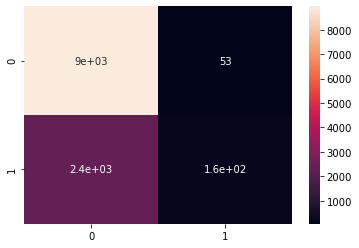

In [518]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Meilleurs paramètres trouvés :", grid.best_params_)
best_model_cat = grid.best_estimator_ 
print("Score d'entraînement :", best_model_cat.score(X_train, y_train_cat, sample_weight=train_weights))
print("Score moyen de cross-validation :", grid.cv_results_['mean_test_score'][0])
print("Score de test :", best_model_cat.score(X_test, y_test_cat, sample_weight=test_weights))

y_pred_train = best_model_cat.predict(X_train)
print("Taux de prédictions à 1 en base d'entraînement :", np.mean(y_pred_train))
y_pred_test = best_model_cat.predict(X_test)
print("Taux de prédictions à 1 en base de test :", np.mean(y_pred_test))
print("Nombre de prédictions à 1 en base de test :", np.sum(y_pred_test))

cm_train = confusion_matrix(y_train_cat, y_pred_train)
cm_test = confusion_matrix(y_test_cat, y_pred_test)
#sns.heatmap(cm_train, annot=True)
sns.heatmap(cm_test, annot=True)



In [102]:
# Simulation de scénario d'investissement :
DF_invest2 = DF_test.copy()
DF_invest2['prediction'] = best_model_cat.predict(X_test)

infl_moy = DF_invest2.cible.mean()
print("Moyenne de l'inflation des vins entre ", year_test, "et", year_test+delta, ":", infl_moy)

DF_invest2 = DF_invest2[DF_invest2.prediction == 1].sample(frac=1)
print("Moyenne de l'inflation des vins en catégorie 1 :", DF_invest2.cible.mean())

nb_domaines = 20
DF_invest2 = DF_invest2.groupby(['pays_region', 'domaine']).first()
DF_invest2 = DF_invest2.head(nb_domaines)
invest_moy = DF_invest2.cible.mean()
print("Moyenne de l'inflation des vins proposés à l'investissement entre ", year_test, "et", year_test+delta, ":", invest_moy)
nb_vins = len(DF_invest2)
print("Voici les", nb_vins, "vins proposés :")
display(DF_invest2)

# => Globalement, les résultats sont moins bons (et plus aléatoires) qu'en régression.

AttributeError: 'DataFrame' object has no attribute 'cible'